## Imports

In [1]:
from functools import partial

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib as mpl
import numpy as np
import scipy.stats

In [3]:
import wlcsim.analytical.homolog as whom

In [4]:
def map_not_none(f, iterable, **kwargs):
    return [x for x in map(partial(f, **kwargs), iterable) if x is not None]

## Parameters

In [5]:
L = 100
mu = 5
num_cells = 1000000
label_loc = (1/3) * L

b = 3  # max plateau is "farthest linear" Ndel=2*L => 4*b**2*L
nuc_radius = 3500  # whatever man, a little less than max plateau

## Generate Cells/Distances/Etc

### Cells/Neighbors

In [6]:
cells = [whom.generate_poisson_homologs(mu=mu, chr_size=L) for i in range(num_cells)]

In [7]:
def get_neighbors(linkages, label_loc):
    i = np.searchsorted(linkages, label_loc)
    neighbors = [None, None]
    if i > 0:
        neighbors[0] = linkages[i - 1]
    if i < len(linkages):
        neighbors[1] = linkages[i]
    return neighbors

In [8]:
neighbors = map_not_none(get_neighbors, cells, label_loc=label_loc)

In [39]:
def is_linkless(neighbors):
    return neighbors[0] is None and neighbors[1] is None
def is_linear(neighbors):
    # xor
    return (neighbors[0] is None) != (neighbors[1] is None)
def is_ring(neighbors):
    return neighbors[0] is not None and neighbors[1] is not None

def P_is_linkless(mu):
    return np.exp(-mu)

def P_is_ring(mu, l0, L):
    return (1 - np.exp(-(mu/L)*label_loc)) * (1 - np.exp(-(mu/L)*(L - label_loc)))

def P_is_linear(mu, l0, L):
    return 1 - P_is_ring(mu, l0, L) - P_is_empty(mu)
                                              

In [10]:
frac_empty = np.mean([*map(is_linkless, neighbors)])
frac_linear = np.mean([*map(is_linear, neighbors)])
frac_ring = np.mean([*map(is_ring, neighbors)])

In [11]:
f"frac_empty is: {frac_empty} ~ {scipy.stats.poisson.pmf(0, mu)} ~ {P_is_empty(mu)}"

'frac_empty is: 0.006869 ~ 0.006737946999085467 ~ 0.006737946999085467'

In [12]:
f"frac_ring is: {frac_ring} ~ {P_is_ring(mu, label_loc, L)}"

'frac_ring is: 0.78235 ~ 0.7821883508142712'

In [13]:
f"frac_linear ({frac_linear}) is what's left: {P_is_linear(mu, label_loc, L)}"

"frac_linear (0.210781) is what's left: 0.21107370218664334"

### Polymer length, N

In [14]:
def get_N(neighbors, L):
    if is_linkless(neighbors):
        return None
    neighbors = neighbors.copy()
    if neighbors[0] is None:
        neighbors[0] = 0
    if neighbors[1] is None:
        neighbors[1] = L
    return 2*(neighbors[1] - neighbors[0])


def get_N_ring(neighbors):
    if not is_ring(neighbors):
        return None
    return 2*(neighbors[1] - neighbors[0])


def get_N_linear(neighbors, L):
    if not is_linear(neighbors):
        return None
    return get_N(neighbors, L)

In [15]:
Ns = map_not_none(get_N, neighbors, L=L)
Ns_ring = map_not_none(get_N_ring, neighbors)
Ns_linear = map_not_none(get_N_linear, neighbors, L=L)

Analytically, we can .... type this up later....

In [16]:
def P_has_left_only(mu, l0, L):
    lam = mu/L
    return (1 - np.exp(-lam*l0)) * np.exp(-lam*(L - l0))

def P_has_right_only(mu, l0, L):
    lam = mu/L
    return (1 - np.exp(-lam*(L - l0))) * np.exp(-lam*l0)

def P_N_linear_left_(N, l0, lam):
    Z_L = (1 - np.exp(-lam*l0)) / lam
    # (1/2)* from jacobian
    return np.zeros_like(N) + (1/2) * (N <= 2*L) \
        *(N >= 2*(L - l0)) * (1/Z_L)*np.exp(-lam*(N/2 - (L - l0)))

def P_N_linear_right_(N, l0, lam):
    Z_R = (1 - np.exp(-lam*(L - l0))) / lam
    # (1/2)* from jacobian
    return np.zeros_like(N) + (1/2) * (N <= 2*L) \
        * (N >= 2*l0) * (1/Z_R)*np.exp(-lam*(N/2 - l0))

def P_N_linear(N, mu, l0, L):
    N = np.array(N)
    lam = mu/L
    left = P_has_left_only(mu, l0, L)
    right = P_has_right_only(mu, l0, L)
    return (left*P_N_linear_left_(N, l0, lam) 
        + right*P_N_linear_right_(N, l0, lam)
    ) / (left + right)

def _inside_interval_weights(N, l0, L):
    line_lengths = (
        (L >= N/2)*(N/2 >= L - l0) * (L - N/2)
      + (L - l0 > N/2)*(N/2 >= l0) * l0
      + (l0 > N/2)*(N/2 >= 0) * N/2
    )
#     total_line_length = np.sqrt(2) * l0 * (L + l0)
    return (0 <= N/2) * (N/2 <= L) * line_lengths
    
def P_N_ring(N, mu, l0, L):
    N = np.array(N)
    lam = mu/L
    Z_LR = (np.exp(lam*L) - np.exp(lam*l0))*(np.exp(lam*l0) - 1) \
         / (lam**2 * np.exp(lam*(L + l0)))
    return np.zeros_like(N) + (1/2) * (N <= 2*L) *(
        (1/Z_LR)*np.exp(-lam*N/2) * _inside_interval_weights(N, l0, L)
    )

def P_N(N, mu, l0, L):
    N = np.array(N)
    return P_is_empty(mu)*np.zeros_like(N) \
        + P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L) \
        + P_is_linear(mu, l0, L)*P_N_linear(N, mu, l0, L)

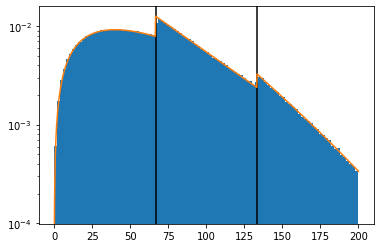

In [17]:
bins = np.arange(0, 2*L + 1, 2)
density, bins, _ = plt.hist(Ns, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N(N, mu, label_loc, L))

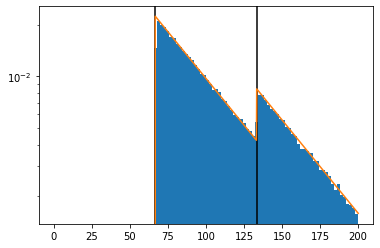

In [18]:
_, _, _ = plt.hist(Ns_linear, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N_linear(N, mu, label_loc, L))

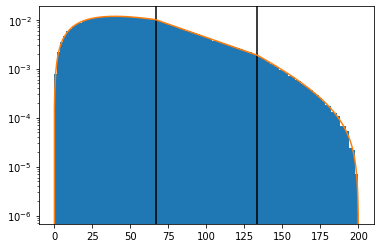

In [19]:
_, _, _ = plt.hist(Ns_ring, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N_ring(N, mu, label_loc, L))

### Distance to Linkage, Ndel ($\Delta$)

In [20]:
def get_Ndel(neighbors, label_loc):
    if neighbors[0] is not None:
        return label_loc - neighbors[0]
    elif neighbors[1] is not None:
        return neighbors[1] - label_loc
    else:
        return None
    
def get_Ndel_ring(neighbors, label_loc):
    if not is_ring(neighbors):
        return None
    return label_loc - neighbors[0]

def get_Ndel_linear(neighbors, label_loc):
    if not is_linear(neighbors):
        return None
    if neighbors[0] is not None:
        return label_loc - neighbors[0]
    return neighbors[1] - label_loc


In [21]:
Ndels = map_not_none(get_Ndel, neighbors, label_loc=label_loc)
Ndels_ring = map_not_none(get_Ndel_ring, neighbors, label_loc=label_loc)
Ndels_linear = map_not_none(get_Ndel_linear, neighbors, label_loc=label_loc)

Analytically, this is the 

$$ P(\text{has left neighbor}) P(\Delta_\text{left} = x | \text{has left neighbor}) 
+ P(\text{no left neighbor}) P(\Delta_\text{right} = x | \text{no left neighbor}) $$

where $ P(\Delta_\text{left} = x) = 0$ for $x > l_0$ and $P(\Delta_\text{right} = x) = 0$ for $x > L - l_0$.

In [22]:
def P_Ndel_ring(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    lam = mu/L
    # if ring, then it has left-side neighbor
    Z_L = (1 - np.exp(-lam*l0)) / lam
    return np.zeros_like(Ndel) + (Ndel >= 0)*(Ndel <= l0)*(1/Z_L)*np.exp(-lam*Ndel)

def P_Ndel_linear_left_(Ndel, l0, lam):
    Z_L = (1 - np.exp(-lam*l0)) / lam
    return np.zeros_like(Ndel) + (Ndel >= 0) \
        * (Ndel <= l0) * (1/Z_L)*np.exp(-lam*Ndel)

def P_Ndel_linear_right_(Ndel, l0, lam):
    Z_R = (1 - np.exp(-lam*(L - l0))) / lam
    return np.zeros_like(Ndel) + (Ndel >= 0) \
        * (Ndel <= L - l0) * (1/Z_R)*np.exp(-lam*Ndel)

def P_Ndel_linear(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    lam = mu/L
    left = P_has_left_only(mu, l0, L)
    right = P_has_right_only(mu, l0, L)
    return (left*P_Ndel_linear_left_(Ndel, l0, lam) 
        + right*P_Ndel_linear_right_(Ndel, l0, lam)
           ) / (left + right)

def P_Ndel(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    return P_is_empty(mu)*np.zeros_like(Ndel) \
        + P_is_ring(mu, l0, L)*P_Ndel_ring(Ndel, mu, l0, L) \
        + P_is_linear(mu, l0, L)*P_Ndel_linear(Ndel, mu, l0, L)
    
# direct computation. should equal "sum of split" version
def _P_Ndel(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    lam = mu/L
    has_left = (1 - np.exp(-lam*l0))
    Z_L = (1 - np.exp(-lam*l0)) / lam
    Z_R = (1 - np.exp(-lam*(L - l0))) / lam
    Ndel_left = (1/Z_L)*np.exp(-lam*Ndel)
    Ndel_right = (1/Z_R)*np.exp(-lam*Ndel)
    return (Ndel >= 0) * (
        (Ndel <= l0) * has_left * Ndel_left 
      + (Ndel <= L - l0) * (1 - has_left) * Ndel_right
    )

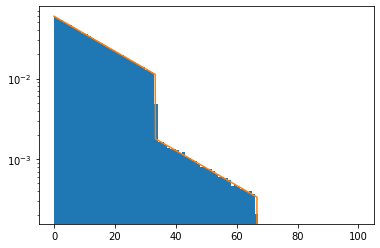

In [23]:
Y, del_bins, _ = plt.hist(Ndels, bins=np.arange(L+1), density=1)
plt.yscale('log')

x = np.linspace(0, L, 1000)
plt.plot(x, P_Ndel(x, mu, label_loc, L))

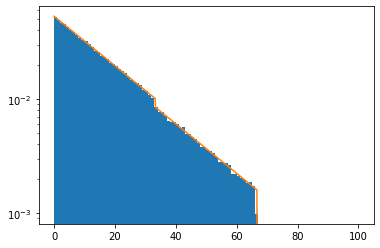

In [24]:
_, _, _ = plt.hist(Ndels_linear, bins=np.arange(L+1), density=1)
plt.yscale('log')

x = np.linspace(0, L, 1000)
plt.plot(x, P_Ndel_linear(x, mu, label_loc, L))

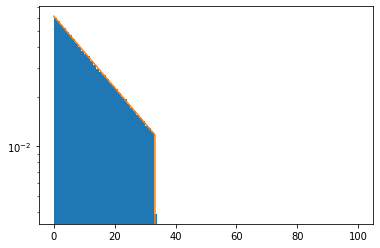

In [25]:
_, _, _ = plt.hist(Ndels_ring, bins=np.arange(L+1), density=1)
plt.yscale('log')

x = np.linspace(0, L, 1000)
plt.plot(x, P_Ndel_ring(x, mu, label_loc, L))

## Analytically compute

### **JOINT** probability of $\Delta$ and $N$

In [26]:
def P_N_joint_Ndel_ring(N, Ndel, mu, l0, L):
    """Returns (N, Ndel)."""
    N = np.array(N)
    Ndel = np.array(Ndel)
    lam = mu/L
    return (1/2) * (0 <= N) * (N <= 2*L) \
        * (N/2 - (L - l0) <= Ndel) \
        * (Ndel <= N/2) * (Ndel <= l0) \
        * lam*np.exp(-lam*(N/2 - Ndel)) / (1 - np.exp(-lam*(L - l0))) \
        * lam*np.exp(-lam*Ndel) / (1 - np.exp(-lam*l0))    

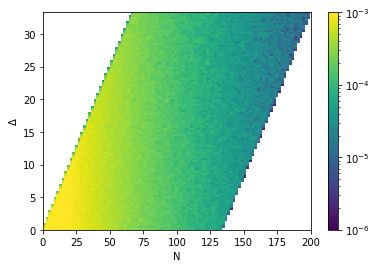

In [27]:
H, xe, ye, im = plt.hist2d(Ns_ring, Ndels_ring, bins=100, density=1, 
                           norm=mcolors.LogNorm(vmin=1e-6, vmax=1e-3))
plt.ylabel('$\Delta$')
plt.xlabel('N')
plt.ylim([0, label_loc])
plt.xlim([0, 2*L])
plt.colorbar()

<ipython-input-28-2a30c015749c>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, P_N_joint_Ndel_ring(xx, yy, mu, label_loc, L)*np.diff(xe)[0]*np.diff(ye)[0],


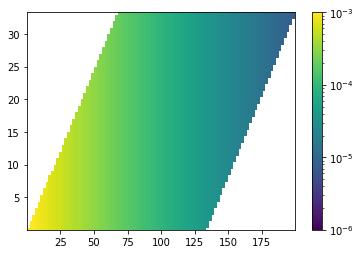

In [28]:
xx, yy = np.meshgrid(xe, ye)
plt.pcolormesh(xx, yy, P_N_joint_Ndel_ring(xx, yy, mu, label_loc, L)*np.diff(xe)[0]*np.diff(ye)[0], 
               norm=mcolors.LogNorm(vmin=1e-6, vmax=1e-3))
plt.colorbar()

### Checking individual integrals

Finally, we check how the analytically determined plateau level compares to the one that comes from averaging many cells together.

In [29]:
# it's a probability, so integrates to 1!
def lower(Ndel):
    return 2*Ndel
def upper(Ndel):
    return 2*(Ndel + L - label_loc)
scipy.integrate.dblquad(P_N_joint_Ndel_ring, 0, label_loc, lower, upper, args=(mu, label_loc, L))

(1.0000000000000002, 1.1102230246251569e-14)

In [32]:
# this guy also integrates to 1
scipy.integrate.quad(P_Ndel_linear_left_, 0, label_loc, args=(label_loc, mu/L))

(0.9999999999999998, 1.1102230246251562e-14)

In [37]:
# this guy also integrates to 1
scipy.integrate.quad(P_Ndel_linear_right_, 0, L - label_loc, args=(label_loc, mu/L))

(1.0, 1.1102230246251565e-14)

In [49]:
def mscd_plateau(mu, label_loc, L, b, nuc_radius):
    def lower(Ndel):
        return 2*Ndel
    def upper(Ndel):
        return 2*(Ndel + L - label_loc)
    def ring_plateau_f(N, Ndel, b, nuc_radius, *args):
        return np.minimum(nuc_radius**2, 2 * b**2 / (1 / (2 * Ndel) + 1 / (N - 2*Ndel))) * P_N_joint_Ndel_ring(N, Ndel, *args)
    def right_linear_plateau(Ndel, b, nuc_radius, *args):
        return np.minimum(4 * b**2 * Ndel, nuc_radius**2) * P_Ndel_linear_right_(Ndel, *args)
    def left_linear_plateau(Ndel, b, nuc_radius, *args):
        return np.minimum(4 * b**2 * Ndel, nuc_radius**2) * P_Ndel_linear_left_(Ndel, *args)
    ring_ave = scipy.integrate.dblquad(
        ring_plateau_f, 0, label_loc, lower, upper, 
        args=(b, nuc_radius, mu, label_loc, L)
    )[0]  # throw away error estimate
    left_linear_ave = scipy.integrate.quad(
        left_linear_plateau, 0, label_loc, 
        args=(b, nuc_radius, label_loc, mu/L)
    )[0]
    right_linear_ave = scipy.integrate.quad(
        right_linear_plateau, 0, L - label_loc,
        args=(b, nuc_radius, label_loc, mu/L)
    )[0]
    return nuc_radius**2 * P_is_linkless(mu) \
        + ring_ave * P_is_ring(mu, label_loc, L) \
        + left_linear_ave * P_has_left_only(mu, label_loc, L) \
        + right_linear_ave * P_has_right_only(mu, label_loc, L)

In [51]:
nuc_radius **2

12250000

In [50]:
mscd_plateau(mu, label_loc, L, b, nuc_radius)

82815.08876465648

In [52]:
from wlcsim.analytical import homolog

In [54]:
hom_plateaus = [homolog.mscd_plateau(linkages, label_loc, L, nuc_radius, b=b) for linkages in cells]

In [55]:
np.mean(hom_plateaus)

84236.90185917765

## Scratch work

If you instead wanted to compute the joint probability function using Bayes rule, and the functions we already have, the only tricky thing you need is $P(\Delta | N, \text{Ring})$.

In [162]:
def P_ring_N(N, mu, l0, L):
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear = P_is_linear(mu, l0, L)*P_N_linear(N, mu, l0, L)
    return ring / (ring + empty + linear)  # faster than "/ P_N()"

def P_linear_N(N, mu, l0, L):
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear = P_is_linear(mu, l0, L)*P_N_linear(N, mu, l0, L)
    return linear / (ring + empty + linear)  # faster than "/ P_N()"

def P_linear_left_N(N, mu, l0, L):
    is_linear_left = P_has_left_only(mu, l0, L)
    is_linear_right = P_has_right_only(mu, l0, L)
    left = is_linear_left / (is_linear_left + is_linear_right)
    right = is_linear_right / (is_linear_left + is_linear_right)
    
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear_left = left*P_N_linear_left_(N, mu, l0, L)
    linear_right = right*P_N_linear_right_(N, mu, l0, L)
    return linear_left / (ring + empty + linear_left + linear_right)

def P_linear_right_N(N, mu, l0, L):
    is_linear_left = P_has_left_only(mu, l0, L)
    is_linear_right = P_has_right_only(mu, l0, L)
    left = is_linear_left / (is_linear_left + is_linear_right)
    right = is_linear_right / (is_linear_left + is_linear_right)
    
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear_left = left*P_N_linear_left_(N, mu, l0, L)
    linear_right = right*P_N_linear_right_(N, mu, l0, L)
    return linear_right / (ring + empty + linear_left + linear_right)


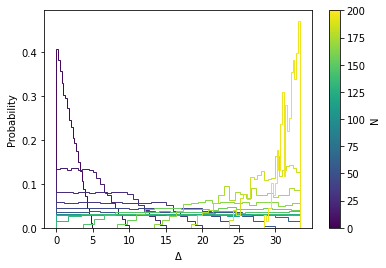

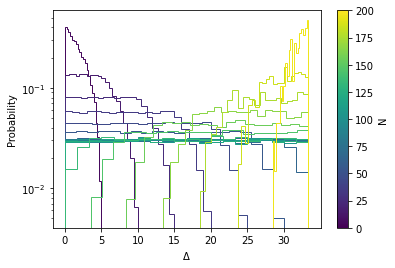

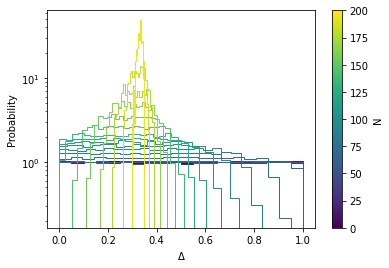

In [161]:
# i = np.argsort(Ns_ring)
# Ns_ring = Ns_ring[i]
# Ndels_ring = Ndels_ring[i]
Ndels_ring = np.array(Ndels_ring)
Ns_ring = np.array(Ns_ring)
scaled_loc = np.array([
    (label_loc - neighbor[0])/(neighbor[1] - neighbor[0]) 
    for neighbor in neighbors if is_ring(neighbor)
])

cmap = mpl.cm.viridis
cnorm_N = mcolors.Normalize(vmin=0, vmax=2*L)

def show_conditional_by_chunk(chunk_size=10, var=Ndels_ring, yscale='linear', split_by=None):
    plt.figure()
    N_bin_edges = np.linspace(0, 2*L, np.round(2*L/chunk_size + 1).astype(int))
    for i, binr in enumerate(N_bin_edges):
        if i == 0:
            continue
        if split_by is not None and i % split_by == 0:
            cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm_N, cmap=cmap))
            cbar.set_label('N')
            plt.xlabel('$\Delta$')
            plt.ylabel('Probability')
            plt.yscale(yscale)
            plt.figure()
        binl = N_bin_edges[i - 1]
        idx = (binl <= Ns_ring) & (Ns_ring < binr)
        plt.hist(var[idx], bins=20, histtype='step', density=1, color=cmap(cnorm_N(np.mean([binr, binl]))))
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm_N, cmap=cmap))
    cbar.set_label('N')
    plt.xlabel('$\Delta$')
    plt.ylabel('Probability')
    plt.yscale(yscale)
    
show_conditional_by_chunk()
show_conditional_by_chunk(yscale='log')

show_conditional_by_chunk(chunk_size=10, var=scaled_loc, yscale='log')

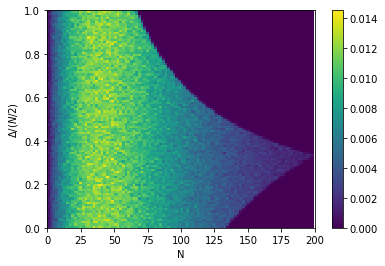

In [118]:
plt.hist2d(Ns_ring, scaled_loc, bins=100, density=1) #, norm=mcolors.LogNorm(vmin=10, vmax=800), bins=100)
plt.ylabel('$\Delta / (N/2)$')
plt.xlabel('N')
plt.ylim([0, 1])
plt.xlim([0, 2*L])
plt.colorbar()

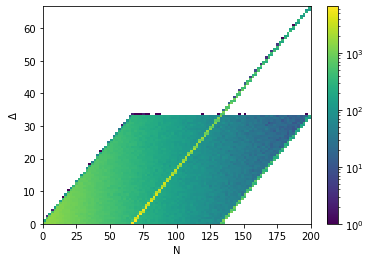

In [120]:
H, xe, ye, im = plt.hist2d(Ns, Ndels, norm=mcolors.LogNorm(), bins=100)
plt.ylabel('$\Delta$')
plt.xlabel('N')
plt.ylim([0, L - label_loc])
plt.xlim([0, 2*L])
plt.colorbar()

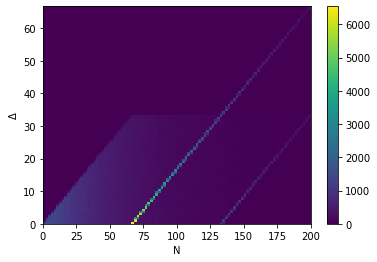

In [122]:
H, xe, ye, im = plt.hist2d(Ns, Ndels, bins=100)
plt.ylabel('$\Delta$')
plt.xlabel('N')
plt.ylim([0, L - label_loc])
plt.xlim([0, 2*L])
plt.colorbar()

Just as a side-note. The reason this is difficult is because the underlying "state" that we're sampling is not a single manifold, but a union of multiple manifolds of dimension 0, 1, and 2:

In [54]:
tLtR = [(-1 if tL is None else tL, -1 if tR is None else tR) for tL, tR in neighbors]
tL = [tL for tL, _ in tLtR]
tR = [tR for _, tR in tLtR]

(Notice in particular that the isolated point (0,0) has probability mass)

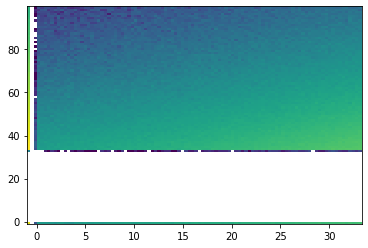

In [55]:
plt.hist2d(tL, tR, bins=100, norm=mcolors.LogNorm());